# Examen des prédictions du modèle estimé par apprentissage de transfert sur les séquences de test

## Estimation par solution exacte des équations d'estimation

In [1]:
import json
import numpy as np
import pandas as pd
import sklearn

In [2]:
import h5py
import cooler

In [3]:
import matplotlib.pyplot as plt

In [4]:
predpath = "/home/bureau/projects/def-bureau/bureau/ran-donnees/PredictNeuronHi-C/akita_pred_sans_final_test/"
predfile = predpath + "preds.h5"

In [5]:
pred = h5py.File(predfile, 'r')
pred

<HDF5 file "preds.h5" (mode r)>

In [6]:
pred.keys()

<KeysViewHDF5 ['preds']>

In [7]:
pred['preds'].shape

(6667, 99681, 48)

In [8]:
targetfile = "/home/bureau/projects/def-bureau/bureau/distiller/iPSC/data/1m/seqs_cov/0.h5"

In [9]:
targets = h5py.File(targetfile, 'r')
targets

<HDF5 file "0.h5" (mode r)>

In [10]:
# Les données de tests sont les 6667 (pred['preds'].shape[0]) dernières
test_targets = targets['targets'][targets['targets'].shape[0]-pred['preds'].shape[0]:,]

In [11]:
test_targets.shape

(6667, 99681)

## Calcul des prédictions

In [12]:
# Lecture des betas
beta_dat = pd.read_csv("beta_final.csv",index_col=0)

In [13]:
beta_dat

,0
0,-0.143654
1,0.037161
2,0.009133
3,0.006468
4,-0.066687
5,-0.013824
6,0.028381
7,-0.033107
8,0.009307
9,-0.025492


In [23]:
X = np.array(pred['preds'][0,:pred['preds'].shape[1],:pred['preds'].shape[2]])
X.shape

(99681, 48)

In [24]:
import statsmodels.api as sm
X = sm.add_constant(X)
X

array([[1.        , 0.42895508, 0.24829102, ..., 0.23193359, 0.20983887,
        0.24890137],
       [1.        , 0.41015625, 0.24060059, ..., 0.21984863, 0.19641113,
        0.2121582 ],
       [1.        , 0.39038086, 0.22058105, ..., 0.20776367, 0.17297363,
        0.18347168],
       ...,
       [1.        , 0.25561523, 0.14953613, ..., 0.25830078, 0.31835938,
        0.06781006],
       [1.        , 0.23022461, 0.14001465, ..., 0.25927734, 0.32080078,
        0.06378174],
       [1.        , 0.24255371, 0.1451416 , ..., 0.26806641, 0.29443359,
        0.0670166 ]])

In [22]:
tmp = np.dot(X,beta_dat)
tmp.shape

(99681, 1)

In [28]:
pred_final = np.zeros((pred['preds'].shape[0],pred['preds'].shape[1]))
for j in range(pred['preds'].shape[0]):
    X = np.array(pred['preds'][j,:pred['preds'].shape[1],:pred['preds'].shape[2]])
    X = sm.add_constant(X)
    pred_final[j,] = np.dot(X,beta_dat)[:,0]

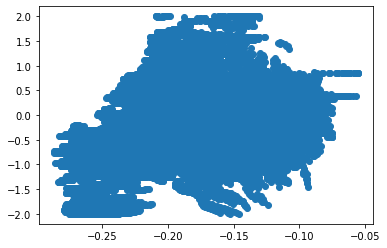

In [48]:
plt.scatter(pred_final[1,:], test_targets[1,:])
plt.show()

## Calcul de l'erreur quadratique moyenne par lignée cellulaire utilisée pour la prédiction

In [30]:
from sklearn.metrics import mean_squared_error
mse_transfer = mean_squared_error(test_targets,pred_final[:,:])

In [31]:
display(mse_transfer)

0.36272814618196003

## Calcul de l'erreur quadratique moyenne pour chaque séquence de 1Mb

In [32]:
mse_transfer_seq = np.zeros(pred_final.shape[0])
for j in range(pred_final.shape[0]):
    mse_transfer_seq[j] = mean_squared_error(test_targets[j,],pred_final[j,])

In [33]:
mse_transfer_dat = pd.DataFrame(mse_transfer_seq)
mse_transfer_dat.to_csv("mse_transfer.csv")

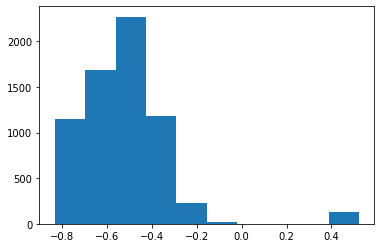

In [34]:
plt.hist(np.log10(mse_transfer_seq))
plt.show()

## Sauvegarde des prédictions

In [37]:
hf = h5py.File('pred_final.h5', 'w')
hf.create_dataset('pred_final',data=pred_final)
hf.close()

In [12]:
predf = h5py.File('pred_final.h5', 'r')
predf

<HDF5 file "pred_final.h5" (mode r)>

In [13]:
predf.keys()

<KeysViewHDF5 ['pred_final']>

In [14]:
predf['pred_final'].shape

(6667, 99681)

In [15]:
from sklearn.metrics import mean_squared_error
mse_transfer = mean_squared_error(test_targets,predf['pred_final'][:,:])

## Calcul de la variance expliquée

In [17]:
from sklearn.metrics import explained_variance_score
r2_transfer = explained_variance_score(test_targets,predf['pred_final'][:,:])

In [18]:
display(r2_transfer)

-1.1428139585678493e-06

In [21]:
r2_transfer_seq = np.zeros(predf['pred_final'].shape[0])
for j in range(predf['pred_final'].shape[0]):
    r2_transfer_seq[j] = explained_variance_score(test_targets[j,],predf['pred_final'][j,])

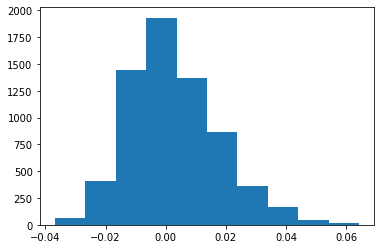

In [23]:
plt.hist(r2_transfer_seq)
plt.show()

In [24]:
np.mean(r2_transfer_seq)

0.002609014144893381